In [ ]:
# Exporting the notebook. It may take several seconds....

[NbConvertApp] Converting notebook demo_p.ipynb to script
[NbConvertApp] Writing 5152 bytes to demo_p.py


pandas==0.25.3
matplotlib==3.0.2
seaborn==0.9.0
numpy==1.19.2


INFO: Successfully output requirements


Train data Shape: (24269, 34)
Test data Shape : (6066, 33)
<class 'pandas.core.frame.DataFrame'>
Index: 24269 entries, train_0 to train_24268
Data columns (total 34 columns):
county                   24235 non-null object
city                     24269 non-null object
zipcode                  24235 non-null float64
address                  23317 non-null object
state                    24269 non-null object
latitude                 24269 non-null float64
longitude                24269 non-null float64
cemetery_dist_miles      24269 non-null float64
nationalhighway_miles    24269 non-null float64
railline_miles           24269 non-null float64
starbucks_miles          24269 non-null float64
walmart_miles            24269 non-null float64
hospital_miles           24269 non-null float64
physician_dist_miles     24269 non-null float64
dentist_dist_miles       24269 non-null float64
opt_dist_miles           24269 non-null float64
vet_dist_miles           24269 non-null float64
farmers_miles

Total  Percent
property_type    887    14.62
address          234     3.86
county             4     0.07
zipcode            4     0.07

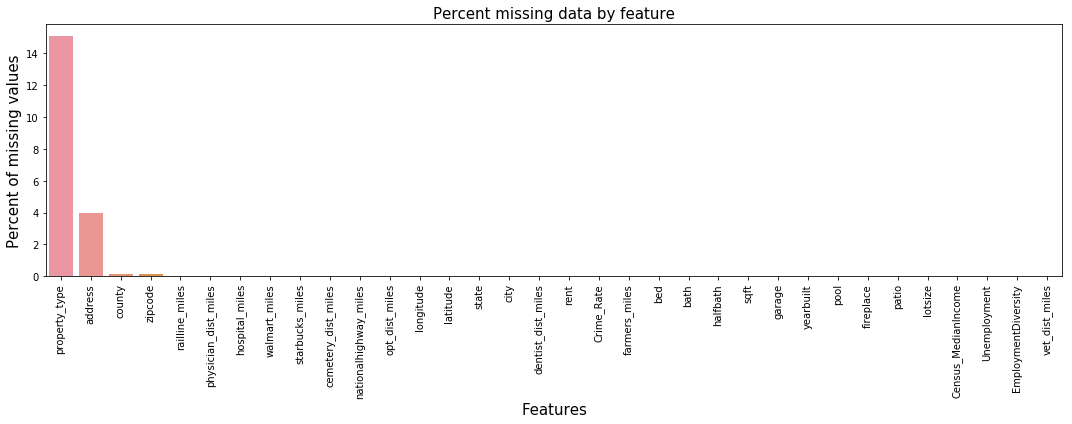

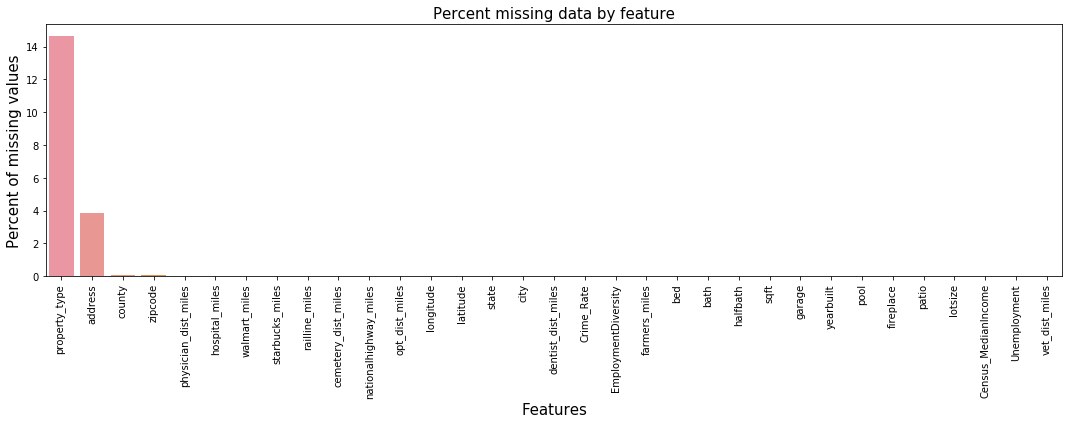

In [1]:
## $xpr_param_component_name = fetch_data
## $xpr_param_component_type = pipeline_job 
## $xpr_param_global_variables = ["train_data"]

# Common imports
import numpy as np
import pandas as pd
import os
#from pandas_profiling import ProfileReport

# To plot pretty figures
import matplotlib.pyplot as plt
import seaborn as sns

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# to display all the columns of the dataframe in the notebook
pd.pandas.set_option('display.max_columns', None)

# Get the data

# Data Fetching - Fetching train and test data from local drive

# Reading train_data.csv file from local drive and stored inside train_data and index set as 'id'.
train_data = pd.read_csv('train_data.csv', index_col='id')
print("Train data Shape:" ,train_data.shape)

# Reading test_data.csv file from local drive and stored inside test_data and index set as 'id'.
test_data = pd.read_csv('test_data.csv',index_col='id')
print("Test data Shape :" ,test_data.shape)

train_data.info()

# Get the count of categorical and numerical features in the training dataset.
cat = len(train_data.select_dtypes(include=['object']).columns)
num = len(train_data.select_dtypes(exclude=['object']).columns)
print('Total Features: ', cat, 'categorical', '+', num, 'numerical', '=', cat+num, 'features')

# Data Pre-processing
# 1. Remove duplicates
# 2. Split training dataset to Xfull and yfull
# 3. Find numerical columns
# 4. Find categorical columns and remove high cardinality(unique values more than 15)
#    Also, remove categorical columns with single unique values
# 5. Updating X1 after clearing out high cardinal and single unique categorical variables from Xfull.
#    (Same step has to be done to test data)
# 6. Check for missing values in X1 training dataset.
# 7. Split X1,yfull to training and validation datas
# 8. Find best approach to handle missing data with numerical columns
# 9. Find best approach to handle missing data with categorical columns(if imputed, then we have to encode it), then check RMSE
# 10.Check or strong correlations between parameters. If so, then remove one of the parameters.

# Function for removing duplicates from housing rental full training dataset
def remove_duplicates():
    train_data.drop_duplicates(inplace=True)
    
    # Find the number of rows and columns inside the training dataset
    print("Shape after dropping duplicates as Row index:" ,train_data.shape)

## Function to get a list of the variables that contain missing values by passing the dataframe
#def check_missing_values(data):
#    vars_with_na = [var for var in data.columns if data[var].isnull().sum() > 0]
#    
#    if len(vars_with_na) > 0:
#        print("\nBelow columns having missing values:")
#        print(data[vars_with_na].isnull().sum(), '\n')
#        print(data[vars_with_na].isnull().mean()*100)
#    else:
#        print("No missing values present!")
#    
#    return vars_with_na

# Function to get a list of the variables that contain missing values and plot by passing the dataframe
def missingValuesInfo(df,plot=False):
    total = df.isnull().sum().sort_values(ascending = False)
    percent = round(total/len(df)*100, 2)
    temp = pd.concat([total, percent], axis = 1,keys= ['Total', 'Percent'])
    
    if sum(total) == 0:
        print("No missing values present!")
        return temp.loc[(temp['Total'] > 0)]
    
    if plot:
        f, ax = plt.subplots(figsize=(15, 6))
        plt.xticks(rotation='90')
        sns.barplot(x=temp.index, y=temp['Percent'])
        plt.xlabel('Features', fontsize=15)
        plt.ylabel('Percent of missing values', fontsize=15)
        plt.title('Percent missing data by feature', fontsize=15)
        save_fig("missing_Values_Info")
    return temp.loc[(temp['Total'] > 0)]

# Step 1 :- Removing duplicate rows/examples from training dataset to avoid bias.
remove_duplicates()

# Check missing values in training and test dataset
#check_missing_values(train_data)
missingValuesInfo(train_data,True)

# Property type has almost 15% of rows with missing values
# Address has almost 4% of rows with missing values
# County and zipcode has less than 0.50% of rows with missing values

# Based on understanding different columns. The missing values possibly happened either due to not recorded or not available.
# county        - Not recorded
# zipcode       - Not recorded
# address       - Not recorded
# property_type - Not recorded

#check_missing_values(test_data)
missingValuesInfo(test_data,True)

# Splitting training dataset to Xfull and yfull